In [1]:
# Don't do this. Do as I say and not as I code.
import sys
sys.path.insert(0, "../") 

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import stan_utils as stan
from data_utils import (generate_data, test_data)
from mpl_utils import mpl_style

plt.style.use(mpl_style)

%matplotlib inline

In [4]:
seed = 42

data_kwds = dict(N=10000, D=10, J=3, K=1, seed=seed, full_output=True,
                 __cluster_mu_theta_scale=1, __cluster_sigma_theta_scale=1)
data, truths = generate_data(**data_kwds)


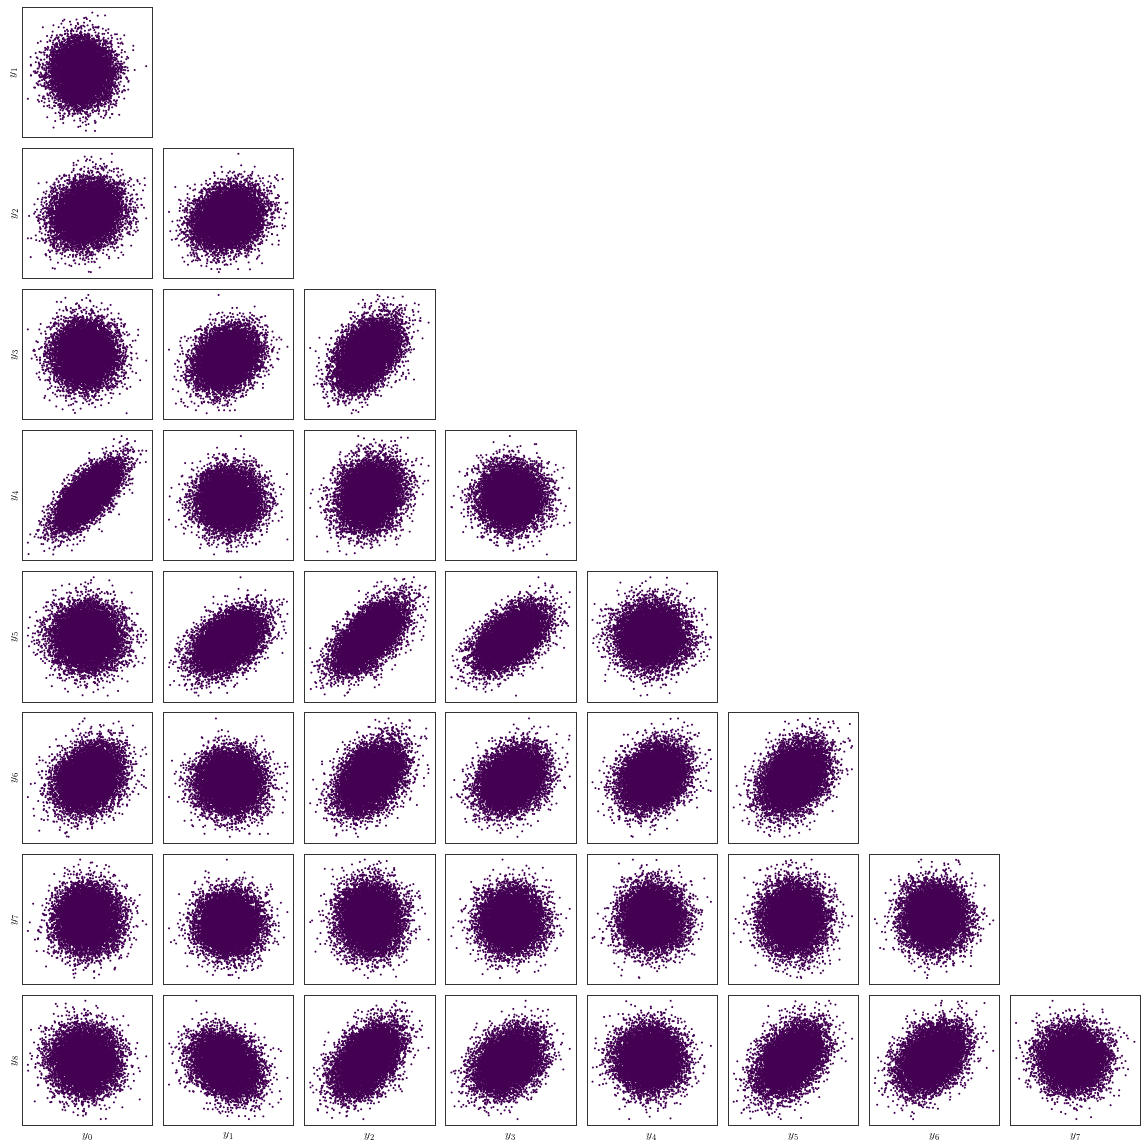

In [6]:
# Plot the data.
A = data["D"] - 1
fig, axes = plt.subplots(A, A, figsize=(2 * A, 2 * A))

ordered = True

y = data["y"]

c = truths["responsibility"]    
indices = np.argsort(c) if ordered else np.arange(len(c))
kwds = dict(s=1, alpha=1, c=c[indices])


for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        if j >= i:
            ax.set_visible(False)
            continue
            
        ax.scatter(y.T[i][indices], y.T[j][indices], **kwds)
        ax.set_xticks([])
        ax.set_yticks([])
        
        if ax.is_last_row():
            ax.set_xlabel(r"$y_{{{0}}}$".format(j))
        if ax.is_first_col():
            ax.set_ylabel(r"$y_{{{0}}}$".format(i))
    
fig.tight_layout()


In [44]:
# Optimize
common_op_kwds = dict(
    tol_obj=1e-16, 
    tol_rel_obj=1e-16,
    tol_rel_grad=1e-16,
    iter=10000)

op_kwds = common_op_kwds.copy()
op_kwds.update(dict(data=data, seed=seed))

model = stan.load_stan_model("../mlf-free.stan")

s_opt = model.optimizing(**op_kwds)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b6abb1008402260f62045c41fc6c50d3 NOW.
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:362: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(np.asarray(v).dtype, int):
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:364: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [49]:
# Extract properties from Sigma.
L = np.linalg.cholesky(s_opt["Sigma"])

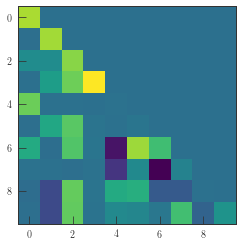

In [50]:
plt.imshow(L, interpolation="nearest")

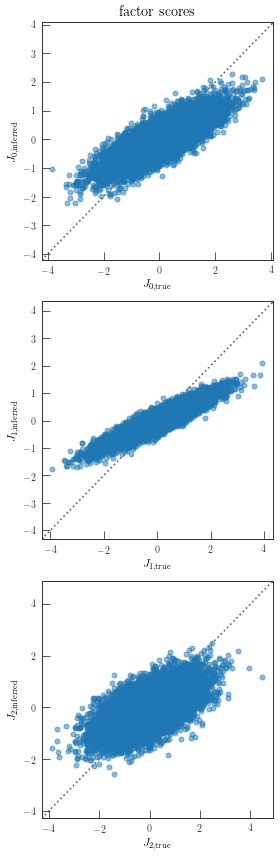

In [51]:
beta_diag_plus_psi = L[np.diag_indices_from(L)]

psi = beta_diag_plus_psi

y = data["y"]
N, D = y.shape
N, J = truths["theta"].shape


factor_loads = L
b = factor_loads/np.sqrt(psi)
scaled_y = y/np.sqrt(psi)

b_sq = np.sum(b**2, axis=1)
factor_scores = np.dot(scaled_y, b.T) * (1 - J/(N - 1) * b_sq)/(1 + b_sq)

fig, axes = plt.subplots(J, figsize=(4, 12))
for j, ax in enumerate(axes):
    ax.scatter(truths["theta"].T[j], factor_scores.T[j], **with_offset_kwds)

    limits = np.hstack([ax.get_xlim(), ax.get_ylim()])
    limits = np.array([np.min(limits), np.max(limits)])
    ax.plot(limits, limits, c="#666666", linestyle=":", zorder=-1)
    ax.set_xlim(limits)
    ax.set_ylim(limits)

    ax.set_xlabel(r"$J_{{{0},\textrm{{true}}}}$".format(j))
    ax.set_ylabel(r"$J_{{{0},\textrm{{inferred}}}}$".format(j))

axes[0].set_title(r"\textrm{factor scores}")
fig.tight_layout()
    


(-0.034983283211708904, 1.6561885566363883)

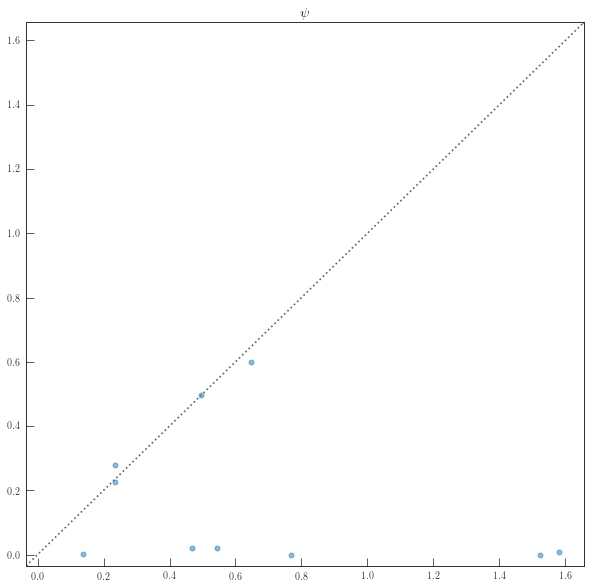

In [52]:
with_offset_kwds = dict(c="tab:blue", alpha=0.5)
without_offset_kwds = dict(c="tab:red", marker="s", zorder=-2, s=50, alpha=0.5)

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(np.diag(truths["psi"]), s_opt["psi"], **with_offset_kwds)
ax.set_title(r"$\psi$")
limits = np.hstack([ax.get_xlim(), ax.get_ylim()])
limits = np.array([limits.min(), limits.max()])
ax.plot(limits, limits, c="#666666", linestyle=":", zorder=-1)
ax.set_xlim(limits)
ax.set_ylim(limits)

KeyError: 'L'

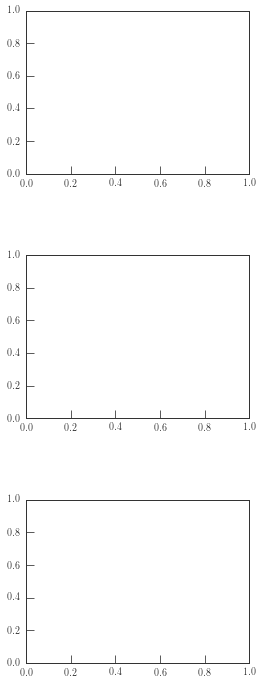

In [53]:
fig, axes = plt.subplots(truths["L"].shape[0], figsize=(4, 12))
for i, ax in enumerate(axes):
    ax.scatter(truths["L"][i], s_opt["L"].T[i], **with_offset_kwds)
    ax.scatter(truths["L"][i], s_opt_no["L"].T[i], **without_offset_kwds)

    limits = np.hstack([ax.get_xlim(), ax.get_ylim()])
    limits = np.array([limits.min(), limits.max()])
    ax.plot(limits, limits, c="#666666", linestyle=":", zorder=-1)
    ax.set_xlim(limits)
    ax.set_ylim(limits)

    ax.set_xlabel(r"$L_{{{0},\textrm{{true}}}}$".format(i))
    ax.set_ylabel(r"$L_{{{0},\textrm{{inferred}}}}$".format(i))

fig.tight_layout()